In [ ]:
from pathlib import Path
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
import pdb
import pickle
import numpy as np
from typing_extensions import Annotated
import time
import batch

from mbnpy import model, config, trans, variable, brc, branch, cpm, operation

HOME = Path().resolve()

%matplotlib inline

# Load data

## Structures

In [2]:
cfg = config.Config(HOME.joinpath('./config.json'))
print(vars(cfg).keys())

scenario to be added later
dict_keys(['file_model', 'infra', 'key', 'max_branches', 'output_path', 'data'])


In [3]:
key = 'York-Merredin'
od_pair = cfg.infra['ODs'][key]

## Damage

In [4]:
file_dmg = "./avg_gmf_69_dmg.csv"
probs = pd.read_csv(file_dmg, index_col=0)
probs.index = probs.index.astype('str')
probs['failure'] = probs['Extensive'] + probs['Complete']
probs = probs.to_dict('index')



Check bridges in the database

In [5]:
print(cfg.infra['nodes'].keys())
print(len(cfg.infra['nodes'].keys()))
print(len(probs))

print(probs['0638'])

dict_keys(['0638', '4815', '0277', '0597', 'Kellerberrin', '0286', '4166A', 'York', '0752', 'Northam', '4154', '4156', '0283', '0639', 'Meckering', 'Cunderdin', '1065', '0714', '0715', '0717', '5093', '0612', '0613', '0576', '0290', '0291', '1047', '1006', '1007', '1050', '0627', 'Merredin', '1149', '0305', '0729', '0730', '0596', '0641', '4184', '0289', '0287', '4556A', '4151', '0288', '0361', '0753', '0754', '0761', '0762', '0763A', '0765', '0285', '0284', '0282', '0281', '0280', '0279', '0278', '0694', '0299', '0300', '0301', '0302', '0303', '0304', '5281', '5099A', '6223A', '5100A', '9186', 'Wooroloo', '4527', '0369', '0692', '0693', '0631A', '0632A', '0633A', '0634', '0637', '0574', '0579', '0580', '0897', '0898', '0589', '0592', '0598', '0602', '0606', '9306', '1046', '1469', '1468', '1504', '1467', '1466', '1465', '1464', '1463', '9187', '1150', '1153', '1154', '0617'])
105
281
{'Slight': 0.4406303260001941, 'Moderate': 0.2345360276437697, 'Extensive': 0.1265510426337899, 'Compl

# Reliability analysis

## Bridges

In [6]:
cpms, varis = {}, {}
comp_names = []
for node in cfg.infra['nodes'].keys():
    if node in probs.keys():
        varis[node] = variable.Variable(name=node, values=['f','s'])

        pf = probs[node]['failure']
        cpms[node] = cpm.Cpm(variables=[varis[node]], no_child=1, C=np.array([[0], [1]]), p=[pf, 1.0-pf])

        comp_names.append(node)
    
    else:
        print(f"Node {node} not in probs.")

print(len(cpms))   

Node Kellerberrin not in probs.
Node York not in probs.
Node Northam not in probs.
Node Meckering not in probs.
Node Cunderdin not in probs.
Node Merredin not in probs.
Node Wooroloo not in probs.
98


## System function

In [7]:
G = cfg.infra['G']
d_time_itc = nx.shortest_path_length(G, source=od_pair[0], target=od_pair[1], weight='weight')
print(d_time_itc)

6547


In [8]:
print(G.edges)
print(G['0638']['4815']['weight'])

[('0638', '4815'), ('0638', '0277'), ('0638', '0612'), ('0638', '0361'), ('0638', 'Northam'), ('4815', 'Northam'), ('4815', '4154'), ('0277', '0613'), ('0277', '0612'), ('0277', '0278'), ('0277', '0752'), ('0277', 'Northam'), ('0597', 'Kellerberrin'), ('0597', '0596'), ('0597', '0598'), ('Kellerberrin', 'Cunderdin'), ('Kellerberrin', '1006'), ('Kellerberrin', '0596'), ('Kellerberrin', '0641'), ('Kellerberrin', '4151'), ('0286', '4166A'), ('0286', '0287'), ('0286', '0285'), ('4166A', 'York'), ('York', '0291'), ('York', '4184'), ('York', '4156'), ('York', '0576'), ('York', '0290'), ('0752', 'Northam'), ('0752', '0612'), ('0752', '0753'), ('Northam', '0613'), ('Northam', '0612'), ('4154', '4156'), ('4156', '0283'), ('0283', '0284'), ('0283', '0282'), ('0639', 'Meckering'), ('0639', '0765'), ('0639', 'Merredin'), ('Meckering', '0284'), ('Meckering', 'Cunderdin'), ('Meckering', '0617'), ('0284', '0285'), ('Cunderdin', '1065'), ('1065', '0714'), ('0714', '0715'), ('0714', '0730'), ('0715', '

In [9]:
def sys_fun(comps_st, G, threshold, od_pair, d_time_itc):
    G_tmp = G.copy()

    for br, st in comps_st.items():
        if st == 0:
            for neigh in G.neighbors(br):
                G_tmp[br][neigh]['weight'] = float('inf')

    d_time = nx.shortest_path_length(G_tmp, source=od_pair[0], target=od_pair[1], weight='weight')

    if d_time > threshold*d_time_itc:
        sys_st = 'f'
        min_comps_st = None
    else:
        sys_st = 's'  

        path = nx.shortest_path(G_tmp, source=od_pair[0], target=od_pair[1], weight='weight')
        min_comps_st = {node: 1 for node in path if node in comps_st.keys()}

    return d_time, sys_st, min_comps_st
    


Test the system function.

In [10]:
# Test 1
comps_st = {x: 1 for x in comp_names}
d_time, sys_st, min_comps_st = sys_fun(comps_st, G, cfg.data['THRESHOLD'], od_pair, d_time_itc)
print(f"Taken time: {d_time}")
print(f"System state: {sys_st}")
print(f"Min components state to ensure the system state: {min_comps_st}")

Taken time: 6547
System state: s
Min components state to ensure the system state: {'0290': 1, '0289': 1, '0288': 1, '4556A': 1, '4151': 1, '1006': 1, '1007': 1, '1050': 1, '0627': 1}


In [11]:
comps_st['0606'] = 0
d_time, sys_st, min_comps_st = sys_fun(comps_st, G, cfg.data['THRESHOLD'], od_pair, d_time_itc)
print(f"Taken time: {d_time}")
print(f"System state: {sys_st}")
print(f"Min components state to ensure the system state: {min_comps_st}")

Taken time: 6547
System state: s
Min components state to ensure the system state: {'0290': 1, '0289': 1, '0288': 1, '4556A': 1, '4151': 1, '1006': 1, '1007': 1, '1050': 1, '0627': 1}


In [12]:
comps_st['0574'] = 0
comps_st['4527'] = 0
d_time, sys_st, min_comps_st = sys_fun(comps_st, G, cfg.data['THRESHOLD'], od_pair, d_time_itc)
print(f"Taken time: {d_time}")
print(f"System state: {sys_st}")
print(f"Min components state to ensure the system state: {min_comps_st}")

Taken time: 6547
System state: s
Min components state to ensure the system state: {'0290': 1, '0289': 1, '0288': 1, '4556A': 1, '4151': 1, '1006': 1, '1007': 1, '1050': 1, '0627': 1}


## Run BRC

In [13]:
sf_brc = lambda comps_st: sys_fun(comps_st, G, cfg.data['THRESHOLD'], od_pair, d_time_itc)
probs_brc = {x: {0: probs[x]['failure'], 1: 1.0-probs[x]['failure']} for x in probs.keys() if x in comp_names}

In [14]:
"""brs, rules, sys_res, monitor = brc.run(probs_brc, sf_brc,
                                       pf_bnd_wr=0.05, max_rules=10, surv_first=True,
                                       active_decomp=10, display_freq=5)

fpath_rule = f"./rules_{od_pair[0]}_{od_pair[1]}.json"
with open(fpath_rule, "w") as f:
    json.dump(rules, f, indent=4)

fpath_br = f"./brs_{od_pair[0]}_{od_pair[1]}.parquet"
branch.save_brs_to_parquet(brs, fpath_br)

fpath_mon = f"./monitor_{od_pair[0]}_{od_pair[1]}.json"
with open(fpath_mon, "w") as f:
    json.dump(monitor, f, indent=4)

fpath_res = f"./sys_res_{od_pair[0]}_{od_pair[1]}.json"
sys_res.to_json( fpath_res, orient='records', lines=True )"""

'brs, rules, sys_res, monitor = brc.run(probs_brc, sf_brc,\n                                       pf_bnd_wr=0.05, max_rules=10, surv_first=True,\n                                       active_decomp=10, display_freq=5)\n\nfpath_rule = f"./rules_{od_pair[0]}_{od_pair[1]}.json"\nwith open(fpath_rule, "w") as f:\n    json.dump(rules, f, indent=4)\n\nfpath_br = f"./brs_{od_pair[0]}_{od_pair[1]}.parquet"\nbranch.save_brs_to_parquet(brs, fpath_br)\n\nfpath_mon = f"./monitor_{od_pair[0]}_{od_pair[1]}.json"\nwith open(fpath_mon, "w") as f:\n    json.dump(monitor, f, indent=4)\n\nfpath_res = f"./sys_res_{od_pair[0]}_{od_pair[1]}.json"\nsys_res.to_json( fpath_res, orient=\'records\', lines=True )'

In [15]:
brs = branch.load_brs_from_parquet(f"./brs_{od_pair[0]}_{od_pair[1]}.parquet")
rules = json.load(open(f"./rules_{od_pair[0]}_{od_pair[1]}.json"))

## System's CPM

In [18]:
varis['sys'] = variable.Variable(name='sys', values=['f','s','u'])

Csys = branch.get_cmat(brs, {x: varis[x] for x in comp_names})
psys = np.ones((Csys.shape[0],1))

cpms['sys'] = cpm.Cpm(variables=[varis['sys']]+[varis[x] for x in comp_names], no_child=1, C=Csys, p=psys)

with open(f'./varis_{od_pair[0]}_{od_pair[1]}.pickle', 'wb') as f:
    pickle.dump(varis, f)
with open(f'./cpms_{od_pair[0]}_{od_pair[1]}.pickle', 'wb') as f:
    pickle.dump(cpms, f)


## Making sense of BRC results

Does the routes coincide with Google's recommended routes?

In [31]:
rule_s_probs = brc.eval_rules_prob(rules['s'], 's', probs_brc)
rule_s_sort_idx = np.argsort(rule_s_probs)[::-1] # sort by descending order of probabilities

print("Survival rules in descending order of probabilities:")
for i in rule_s_sort_idx:
    print(f"Prob: {rule_s_probs[i]:.3e}, {rules['s'][i]}")

Survival rules in descending order of probabilities:
Prob: 9.437e-01, {'4166A': 1, '0286': 1, '0287': 1, '4556A': 1, '4151': 1, '1006': 1, '1007': 1, '1050': 1, '0627': 1}
Prob: 9.387e-01, {'4166A': 1, '0286': 1, '0285': 1, '0284': 1, '1006': 1, '1007': 1, '1050': 1, '0627': 1}
Prob: 8.837e-01, {'4156': 1, '0283': 1, '0284': 1, '1006': 1, '1007': 1, '1050': 1, '0627': 1}
Prob: 8.325e-01, {'4184': 1, '0289': 1, '0288': 1, '4556A': 1, '4151': 1, '1006': 1, '1007': 1, '1050': 1, '0627': 1}
Prob: 8.256e-01, {'0290': 1, '0289': 1, '0288': 1, '4556A': 1, '4151': 1, '0641': 1}
Prob: 8.256e-01, {'0290': 1, '0289': 1, '0288': 1, '4556A': 1, '4151': 1, '1006': 1, '1007': 1, '1050': 1, '0627': 1}
Prob: 7.975e-01, {'0290': 1, '0579': 1, '0580': 1, '0897': 1, '0898': 1, '0589': 1, '0592': 1, '0596': 1, '1006': 1, '1007': 1, '1050': 1, '0627': 1}
Prob: 7.609e-01, {'4156': 1, '0283': 1, '0282': 1, '0281': 1, '0280': 1, '0279': 1, '0278': 1, '0277': 1, '0613': 1, '1149': 1, '1150': 1, '1153': 1, '1154

# Simulation of real-time update

## Load data

In [46]:
# damage data from ShakeCast
file_dmg = "./avg_gmf_69_dmg.csv"
probs_new = pd.read_csv(file_dmg, index_col=0)
probs_new.index = probs_new.index.astype('str')
probs_new['failure'] = probs_new['Extensive'] + probs_new['Complete']
probs_new = probs_new.to_dict('index')

In [52]:
# Previous analysis results
cpms = pickle.load(open(f'./cpms_{od_pair[0]}_{od_pair[1]}.pickle', 'rb'))
varis = pickle.load(open(f'./varis_{od_pair[0]}_{od_pair[1]}.pickle', 'rb'))

rules = json.load(open(f"./rules_{od_pair[0]}_{od_pair[1]}.json"))

## Update Probability distributions by ShakeCast data

In [57]:
comp_names = [v.name for v in cpms['sys'].variables[1:]]

for x in comp_names:
    cpms[x].p = np.array([probs_new[x]['failure'], 1.0-probs_new[x]['failure']]).T

## Results

### System Survival Probability

In [58]:
st = time.time()
Msys = operation.prod_Msys_and_Mcomps(cpms['sys'], [cpms[x] for x in comp_names])
print(f"Elapsed time for system probability calculation: {time.time()-st:.3f} s")

Elapsed time for system probability calculation: 1.485 s


In [59]:
pf_sys = sum(p for i, p in enumerate(Msys.p) if Msys.C[i,0]==0)
if isinstance(pf_sys, int):
    pf_sys = 0.0
else:
    pf_sys = pf_sys[0]

ps_sys = sum(p for i, p in enumerate(Msys.p) if Msys.C[i,0]==1)
if isinstance(ps_sys, int):
    ps_sys = 0.0
else:
    ps_sys = ps_sys[0]

print(f"System failure probability bounds: {pf_sys:.3e}, {1.0-ps_sys:.3e}")

System failure probability bounds: 0.000e+00, 2.838e-05


## Paths survival probability

In [60]:
probs_new_brc = {x: {0: probs_new[x]['failure'], 1: 1.0-probs_new[x]['failure']} for x in probs_new.keys() if x in comp_names}

rule_s_probs = brc.eval_rules_prob(rules['s'], 's', probs_new_brc)
rule_s_sort_idx = np.argsort(rule_s_probs)[::-1] # sort by descending order of probabilities

print("Survival rules in descending order of probabilities:")
for i in rule_s_sort_idx:
    print(f"Prob: {rule_s_probs[i]:.3e}, {rules['s'][i]}")

Survival rules in descending order of probabilities:
Prob: 9.437e-01, {'4166A': 1, '0286': 1, '0287': 1, '4556A': 1, '4151': 1, '1006': 1, '1007': 1, '1050': 1, '0627': 1}
Prob: 9.387e-01, {'4166A': 1, '0286': 1, '0285': 1, '0284': 1, '1006': 1, '1007': 1, '1050': 1, '0627': 1}
Prob: 8.837e-01, {'4156': 1, '0283': 1, '0284': 1, '1006': 1, '1007': 1, '1050': 1, '0627': 1}
Prob: 8.325e-01, {'4184': 1, '0289': 1, '0288': 1, '4556A': 1, '4151': 1, '1006': 1, '1007': 1, '1050': 1, '0627': 1}
Prob: 8.256e-01, {'0290': 1, '0289': 1, '0288': 1, '4556A': 1, '4151': 1, '0641': 1}
Prob: 8.256e-01, {'0290': 1, '0289': 1, '0288': 1, '4556A': 1, '4151': 1, '1006': 1, '1007': 1, '1050': 1, '0627': 1}
Prob: 7.975e-01, {'0290': 1, '0579': 1, '0580': 1, '0897': 1, '0898': 1, '0589': 1, '0592': 1, '0596': 1, '1006': 1, '1007': 1, '1050': 1, '0627': 1}
Prob: 7.609e-01, {'4156': 1, '0283': 1, '0282': 1, '0281': 1, '0280': 1, '0279': 1, '0278': 1, '0277': 1, '0613': 1, '1149': 1, '1150': 1, '1153': 1, '1154

## Component importance measure

$BM_n=P(S=1 | X_n=1) - P(S=1 | X_n=0)$ <br>
$CI_n\propto BM_n \cdot P(X_n=0)$

In [70]:
# Bounds are obtained for incomplete BnB
BMs, CIs = {}, {}
for idx, comp in enumerate(comp_names):

    P_x0 = cpms[comp].p[0]
    P_x1 = cpms[comp].p[1]

    P_s1_x1 = sum(p for i, p in enumerate(Msys.p) if Msys.C[i,0]==1 and Msys.C[i,idx+1]==1)
    P_s0_x1 = sum(p for i, p in enumerate(Msys.p) if Msys.C[i,0]==1 and Msys.C[i,idx+1]==0)
    P_s1_x0 = sum(p for i, p in enumerate(Msys.p) if Msys.C[i,0]==0 and Msys.C[i,idx+1]==1)
    P_s0_x0 = sum(p for i, p in enumerate(Msys.p) if Msys.C[i,0]==0 and Msys.C[i,idx+1]==0)

    # BM
    P_s1_cond_x1_bnd = (P_s1_x1/P_x1, (1.0-P_s0_x1-P_s1_x0-P_s0_x0)/P_x1)
    P_s1_cond_x0_bnd = (P_s1_x0/P_x0, (1.0-P_s0_x1-P_s1_x0-P_s0_x0)/P_x0)

    BM_bounds = (P_s1_cond_x1_bnd[0]-P_s1_cond_x0_bnd[1], P_s1_cond_x1_bnd[1]-P_s1_cond_x0_bnd[0])
    BMs[comp] = (BM_bounds[0][0], BM_bounds[1][0])

    # CI
    CI_bounds = (BM_bounds[0]*P_x0, BM_bounds[1]*P_x0)
    CIs[comp] = (CI_bounds[0][0], CI_bounds[1][0])


In [90]:
print(CIs)

{'0638': (-0.9999994087973968, 0.1857575086970202), '4815': (-0.9999969954280967, 0.9440448814737499), '0277': (-0.9999859654897005, 0.10424415367382142), '0597': (-1.0, 1.8029494440899234e-05), '0286': (-0.9973794282415089, 0.001311899002493405), '4166A': (-0.9999953430327504, 2.33134109425173e-06), '0752': (-1.0, 0.14270632027903418), '4154': (-0.999998333458525, 0.5236319848412865), '4156': (-0.9998309658750767, 0.06329707817134095), '0283': (-0.9999955428861651, 0.0016489920790621938), '0639': (-1.0, 7.319322631429121e-07), '1065': (-0.9999999999999999, 1.4246294539137609e-05), '0714': (-1.0, 3.6776124716679e-05), '0715': (-1.0, 9.199172510567064e-05), '0717': (-0.9999999999999999, 3.5262803280601246e-08), '5093': (-1.0, 3.871974846211027e-11), '0612': (-0.9999986736848036, 0.13937269310293685), '0613': (-0.9999852329154773, 0.0796710034882149), '0576': (-1.0, 0.045869477863059796), '0290': (-0.9997631448046751, 0.20399663105137278), '0291': (-1.0, 0.0728958262960585), '1047': (-1.

In [95]:
print(CIs_error)

[[1.94404188 1.90948218 1.52363032 1.4125924  1.20375978 1.19284632
  1.18575692 1.14270632 1.13937137 1.10423012]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]


['0287', '0284', '4151', '4556A', '0286', '4184', '0290', '4156', '0285', '0613']


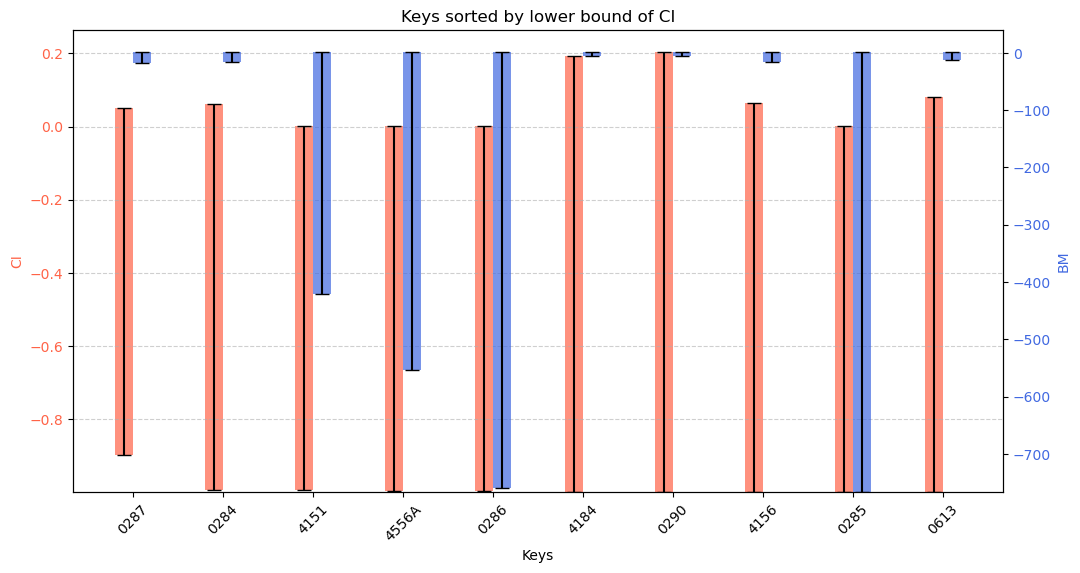

In [103]:
sorted_CIs_keys = sorted(CIs.keys(), key=lambda x: CIs[x][0], reverse=True)
sorted_CIs_keys = sorted_CIs_keys[:10]
print(sorted_CIs_keys)

BMs_upper = [BMs[x][1] for x in sorted_CIs_keys]
CIs_upper = [CIs[x][1] for x in sorted_CIs_keys]

BMs_lower= [BMs[x][0] for x in sorted_CIs_keys]
CIs_lower = [CIs[x][0] for x in sorted_CIs_keys]

BMs_error = np.array([
    [BMs_upper[i] - BMs_lower[i] for i in range(len(BMs_upper))],  # Lower errors
    [0 for _ in range(len(BMs_upper))]  # Upper errors (0 because the bar already reaches BMs_upper)
])

CIs_error = np.array([
    [CIs_upper[i] - CIs_lower[i] for i in range(len(CIs_upper))],  # Lower errors
    [0 for _ in range(len(CIs_upper))]  # Upper errors
])

x = np.arange(len(sorted_CIs_keys))
width = 0.2

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

bars1 = ax1.bar(x - width/2, CIs_error[0], width, bottom=CIs_lower, yerr=CIs_error, capsize=5, color='tomato', alpha=0.7, label="CI")
bars2 = ax2.bar(x + width/2, BMs_error[0], width, bottom=BMs_lower, yerr=BMs_error, capsize=5, color='royalblue', alpha=0.7, label="BM")

# Formatting
ax1.set_xlabel("Keys")
ax1.set_ylabel("CI", color='tomato')
ax1.tick_params(axis='y', labelcolor='tomato')

ax2.set_ylabel("BM", color='royalblue')
ax2.tick_params(axis='y', labelcolor='royalblue')

ax1.set_xticks(x)
ax1.set_xticklabels(sorted_CIs_keys, rotation=45)
plt.title("Keys sorted by lower bound of CI")

ax1.grid(axis='y', linestyle='--', alpha=0.6)

# Show plot
plt.show()